<a href="https://colab.research.google.com/github/SusanaAlvarezC/Monografia/blob/main/Monograf%C3%ADaDetecci%C3%B3nFraudes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autores**:

*  ## Luis Miguel Roman            | Luism.romanp@udea.edu.co
*  ## Susana Álvarez               | susana.alvarezc@udea.edu.co

# **Descripción data set**:

Contiene los registros de 9105 instalaciones eléctricas de una compañía de distrbución de energía eléctrica en Chile con la variable target donde indica si tuvo Fraude.

| was_fraud | Cantidad |
|-----------|----------|
|     0     |   5167   |
|     1     |   3938   |

## 1. Librerias y cargue de datos

In [ ]:
# Librerías para la extracción de datos desde GitHub
import requests  # Para hacer solicitudes HTTP y descargar datos desde una URL
from io import StringIO  # Para trabajar con datos en formato cadena


# Tratamiento de datos
import pandas as pd  # Para el análisis y manipulación de datos tabulares
import numpy as np  # Para cálculos numéricos y manipulación de arrays
import matplotlib.pyplot as plt  # Para crear gráficos y visualizaciones
import seaborn as sns  # Para visualización estadística
import math  # Para funciones matemáticas comunes


# Librerías para la modelización y evaluación de datos
from statsmodels.stats.outliers_influence import variance_inflation_factor  # Para evaluar multicolinealidad
from sklearn.neighbors import LocalOutlierFactor  # Para la detección de valores atípicos

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Extracción data set
url = 'https://raw.githubusercontent.com/SusanaAlvarezC/Monografia/main/consumos_energia.csv'

response = requests.get(url)

if response.status_code == 200:
    # Convierte el contenido descargado a un objeto StringIO para poder leerlo como archivo
    csv_data = StringIO(response.text)
    df = pd.read_csv(csv_data)
else:
    print("No se pudo descargar el archivo CSV.")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9105 entries, 0 to 9104
Columns: 384 entries, nivel_de_voltaje to N665
dtypes: float64(299), int64(79), object(6)
memory usage: 26.7+ MB


In [ ]:
df.head()

,nivel_de_voltaje,actividad_economica,provincia,area_riesgo,tipo_cliente,was_fraud,tarifa,N126,N155,N156,...,N656,N657,N658,N659,N660,N661,N662,N663,N664,N665
0,34.5 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,1,NaN,0,4,NaN,...,287.0,72,NaN,NaN,NaN,0,0,NaN,NaN,60.0
1,13.8 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,1,NaN,0,0,NaN,...,231.5,82,NaN,NaN,NaN,0,0,NaN,NaN,38.0
2,34.5 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,1,NaN,0,0,NaN,...,253.0,82,NaN,NaN,NaN,0,0,NaN,NaN,71.0
3,34.5 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,1,NaN,0,0,NaN,...,667.0,82,NaN,398.142857,234.1875,0,16,NaN,NaN,264.0
4,34.5 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,1,NaN,0,0,NaN,...,401.0,82,NaN,NaN,NaN,0,0,NaN,NaN,219.0


In [ ]:
#Distribución variable objetivo

df['was_fraud'].value_counts()

0    5167
1    3938
Name: was_fraud, dtype: int64

### 2. Funciones

In [ ]:
def plot_multiples_graficas(df, cols, num_cols, num_rows, plot_type, target_var=None, figsize=(16, 8)):
    """
    Crea múltiples gráficos en una única figura para visualizar variables en un DataFrame.

    Parameters:
    -----------
    - df (DataFrame): El DataFrame que contiene los datos a visualizar.
    - cols (list): Lista de nombres de las columnas que se desean visualizar.
    - num_cols (int): Número de columnas en la disposición de los gráficos.
    - num_rows (int): Número de filas en la disposición de los gráficos.
    - plot_type (str): Tipo de gráfico a generar. Puede ser 'c' (countplot), 'b' (boxplot) o 's' (scatterplot).
    - target_var (str, opcional): Variable objetivo para gráficos de tipo 'b' (boxplot) y 's' (scatterplot).
    - figsize (tuple, opcional): Tamaño de la figura (ancho, alto).

    Returns:
    --------
    No retorna un valor, pero muestra los gráficos en la salida.

    Raises:
    -------
    - ValueError: Se genera un error si target_var no se proporciona para gráficos de tipo 'b' y 's'.

    Example:
    --------
    plot_multiples_graficas(df, ['columna1', 'columna2', 'columna3'], 2, 2, 'c')
    """

    fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
    axs = axs.ravel()

    for i, col in enumerate(cols):
        if plot_type == 'c':
            sns.countplot(x=col, data=df, ax=axs[i], dodge=False)
        elif plot_type == 'b':
            sns.boxplot(x=col, y=target_var, data=df, ax=axs[i])
        elif plot_type == 's':
            sns.scatterplot(x=col, y=target_var, data=df, ax=axs[i])
        axs[i].set_title(col)

    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


## 3. Limpieza de datos (Data Cleaning)

#### 3.1 Manejo de nulos

In [ ]:
# Calcular el porcentaje de NaN en cada columna
nan_percentages = df.isna().mean()

# Ordenar los porcentajes de mayor a menor
nan_percentages = nan_percentages.sort_values(ascending=False)

# Mostrar los porcentajes de NaN
print(nan_percentages)


N271    1.0
N406    1.0
N246    1.0
N268    1.0
N269    1.0
       ... 
N512    0.0
N591    0.0
N514    0.0
N515    0.0
N524    0.0
Length: 384, dtype: float64


In [ ]:
# Definir un umbral de eliminación de registros (40% en este caso) Si una columna tiene más del 40% de valores faltantes (NaN), se eliminará..
umbral = 0.4

# Filtrar las columnas que superen el umbral de NaN.
columnas_a_eliminar = nan_percentages[nan_percentages > umbral].index

# Mostrar información sobre las columnas a eliminar.
print("Resumen de la Limpieza de Datos:\n\n")
print(f"Número total de columnas antes de eliminar: {len(df.columns)}")
print(f"Número de columnas a eliminar: {len(columnas_a_eliminar)}")
print(f"Columnas a eliminar: {', '.join(columnas_a_eliminar)}\n\n")

# Eliminar las columnas con al menos 40% de NaN.
df = df.drop(columns=columnas_a_eliminar)

# Calcular la mediana de las columnas restantes que tienen NaN y reemplazar los NaN por la mediana.
df = df.fillna(df.median())

# Mostrar información después de la eliminación.
print(f"Número total de columnas después de eliminar: {len(df.columns)}")


Resumen de la Limpieza de Datos:


Número total de columnas antes de eliminar: 384
Número de columnas a eliminar: 92
Columnas a eliminar: N271, N406, N246, N268, N269, N192, N277, N156, N272, N262, N324, N314, N309, N310, N313, N325, N245, N393, N401, N391, N392, N414, N196, N559, N562, N563, N564, N565, N570, N571, N558, N580, N578, N577, N576, N583, N582, N581, N579, N186, N185, N400, N552, N263, N258, N553, N555, N423, N424, N436, N441, N550, N551, N421, N422, N435, N560, N561, N572, N569, N568, N567, N566, N573, N408, N407, N165, N275, N164, N174, N660, N502, N413, N399, N425, N371, N279, N369, N426, N285, N173, N168, N163, N175, N170, N169, N659, N182, N181, N179, N178, N176


Número total de columnas después de eliminar: 292


<ipython-input-11-5b1651ccf738>:17: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.median())


#### 3.2 Duplicados y variables numéricas en 0

In [ ]:
# Verificación y eliminación de registros duplicados
# Identifica y muestra las filas duplicadas en el DataFrame
duplicados = df.loc[df.duplicated()]
print("Registros duplicados:")
print(duplicados)



# Mostrar número de registros antes de la eliminación de duplicados
print(f"\n\nNúmero total de filas antes de eliminar duplicados: {len(df)}")

# Elimina las filas duplicadas del DataFrame
df = df.drop_duplicates()


# Mostrar número de registros después de la eliminación de duplicados
print(f"\n\nNúmero total de filas despues de eliminar duplicados: {len(df)}")

# Verifica si todas las filas tienen el valor 0 en cada columna numérica
# Identifica las columnas numéricas en las que todas las filas tienen el valor 0
columnas_a_eliminar = [col for col in df.columns if (df[col] == 0).all() and pd.api.types.is_numeric_dtype(df[col])]

print("\n\nColumnas con todos los valores iguales a 0:")
print(f'Columnas a eliminar: {", ".join(columnas_a_eliminar)}')

# Elimina las columnas identificadas con valores iguales a 0
df = df.drop(columns=columnas_a_eliminar)


# Mostrar información después de la eliminación.
print(f"\n\nNúmero total de columnas después de eliminar: {len(df.columns)}")


Registros duplicados:
     nivel_de_voltaje actividad_economica provincia        area_riesgo  \
4215        34.5 kV-Y               Otras  SAN JOSÉ     ZONA PELIGROSA   
5028              NaN               Otras   HEREDIA  ZONA NO PELIGROSA   
5286        34.5 kV-Y               Otras  SAN JOSÉ  ZONA NO PELIGROSA   
7158        34.5 kV-Y               Otras  ALAJUELA  ZONA NO PELIGROSA   

     tipo_cliente  was_fraud       tarifa  N126  N155      N158  ...  N653  \
4215      NATURAL          0  RESIDENCIAL     0     0  0.001576  ...     0   
5028      NATURAL          0  RESIDENCIAL     0    15  0.000000  ...    10   
5286      NATURAL          0  RESIDENCIAL     0     0  0.000000  ...    85   
7158      NATURAL          0  RESIDENCIAL     0     0  0.000000  ...    99   

       N654   N656  N657   N658  N661  N662   N663   N664  N665  
4215  159.0  226.0     0  209.0     0     0  333.0  118.0  51.0  
5028  159.0  226.0     0    0.0     0     0    0.0    0.0  51.0  
5286    0.0    0.0

#### 3.4 Eliminación de Variables Altamente Correlacionadas

Variables altamente correlacionadas proporcionan información similar. Cuando dos o más variables están fuertemente correlacionadas, no aportan información adicional única al modelo y pueden aumentar la complejidad innecesaria.

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = df.corr().abs()

# Crear una matriz booleana para identificar las correlaciones por encima del umbral
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

# Encontrar índices de variables con correlación alta
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]


# Imprimir el número de columnas a eliminar
print(f"Número de columnas a eliminar debido a alta correlación: {len(to_drop)}")

# Eliminar las variables con correlación alta del DataFrame
df = df.drop(columns=to_drop)

# Imprimir las variables eliminadas
print("Variables eliminadas debido a alta correlación:", to_drop)

# Mostrar información después de la eliminación.
print(f"\n\nNúmero total de columnas después de eliminar: {len(df.columns)}")


<ipython-input-16-7a986d98fd96>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr().abs()


Número de columnas a eliminar debido a alta correlación: 219
Variables eliminadas debido a alta correlación: ['N162', 'N180', 'N183', 'N184', 'N187', 'N189', 'N190', 'N191', 'N193', 'N194', 'N195', 'N201', 'N202', 'N205', 'N206', 'N207', 'N216', 'N226', 'N227', 'N228', 'N230', 'N238', 'N255', 'N256', 'N259', 'N261', 'N264', 'N265', 'N266', 'N270', 'N273', 'N274', 'N278', 'N280', 'N281', 'N282', 'N284', 'N286', 'N287', 'N288', 'N305', 'N306', 'N307', 'N308', 'N311', 'N312', 'N316', 'N317', 'N318', 'N319', 'N320', 'N321', 'N322', 'N323', 'N329', 'N330', 'N331', 'N332', 'N333', 'N347', 'N348', 'N349', 'N350', 'N352', 'N356', 'N357', 'N358', 'N359', 'N361', 'N362', 'N363', 'N364', 'N365', 'N372', 'N373', 'N374', 'N375', 'N376', 'N380', 'N382', 'N387', 'N389', 'N398', 'N409', 'N416', 'N417', 'N418', 'N427', 'N428', 'N431', 'N432', 'N433', 'N434', 'N437', 'N438', 'N439', 'N440', 'N443', 'N444', 'N445', 'N446', 'N448', 'N449', 'N450', 'N451', 'N452', 'N453', 'N455', 'N456', 'N457', 'N458', 'N

<ipython-input-16-7a986d98fd96>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))


#### 3.5 Selección y Eliminación de Variables con Alta Multicolinealidad

No se encuentra multicolinealidad entre las variables. Las variables predictoras seleccionadas son independientes entre sí, lo que significa que cada variable aporta información única al modelo.

In [ ]:
numCols = df.select_dtypes(include=['float64', 'int32', 'int64']).columns.tolist()
numCols.remove('was_fraud')

# Evaluar la multicolinealidad entre variables predictoras
# Crear un DataFrame auxiliar para calcular el VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = numCols

# Calcular el VIF para cada variable numérica
vif_data["VIF"] = [variance_inflation_factor(df[numCols].values, i) for i in range(len(numCols))]


# Identificar las variables con VIF > 5
variables_con_alto_vif = vif_data[vif_data['VIF'] > 5]

print(vif_data )
# Obtener los nombres de las columnas con alto VIF
columnas_a_eliminar = variables_con_alto_vif['Variable'].tolist()

print(f'Columnas a eliminar: {", ".join(columnas_a_eliminar)}')

# Eliminar las variables con alto VIF del DataFrame df
df = df.drop(columns=columnas_a_eliminar)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_

   Variable       VIF
0      N155  1.698692
1      N158  1.589881
2      N159  1.845659
3      N161  2.037265
4      N166  1.941216
..      ...       ...
56     N650  1.047236
57     N651  1.050632
58     N654  1.504550
59     N661  1.047151
60     N662  1.094981

[61 rows x 2 columns]
Columnas a eliminar: 


## 4. Visualización de datos

#### 4.1 Variables de entrada




In [ ]:
#Lista de variables categóricas
catCols = df.select_dtypes(include = ["object", 'category']).columns.tolist()
df[catCols].head()

,nivel_de_voltaje,actividad_economica,provincia,area_riesgo,tipo_cliente,tarifa
0,34.5 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,NaN
1,13.8 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,NaN
2,34.5 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,NaN
3,34.5 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,NaN
4,34.5 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,NaN


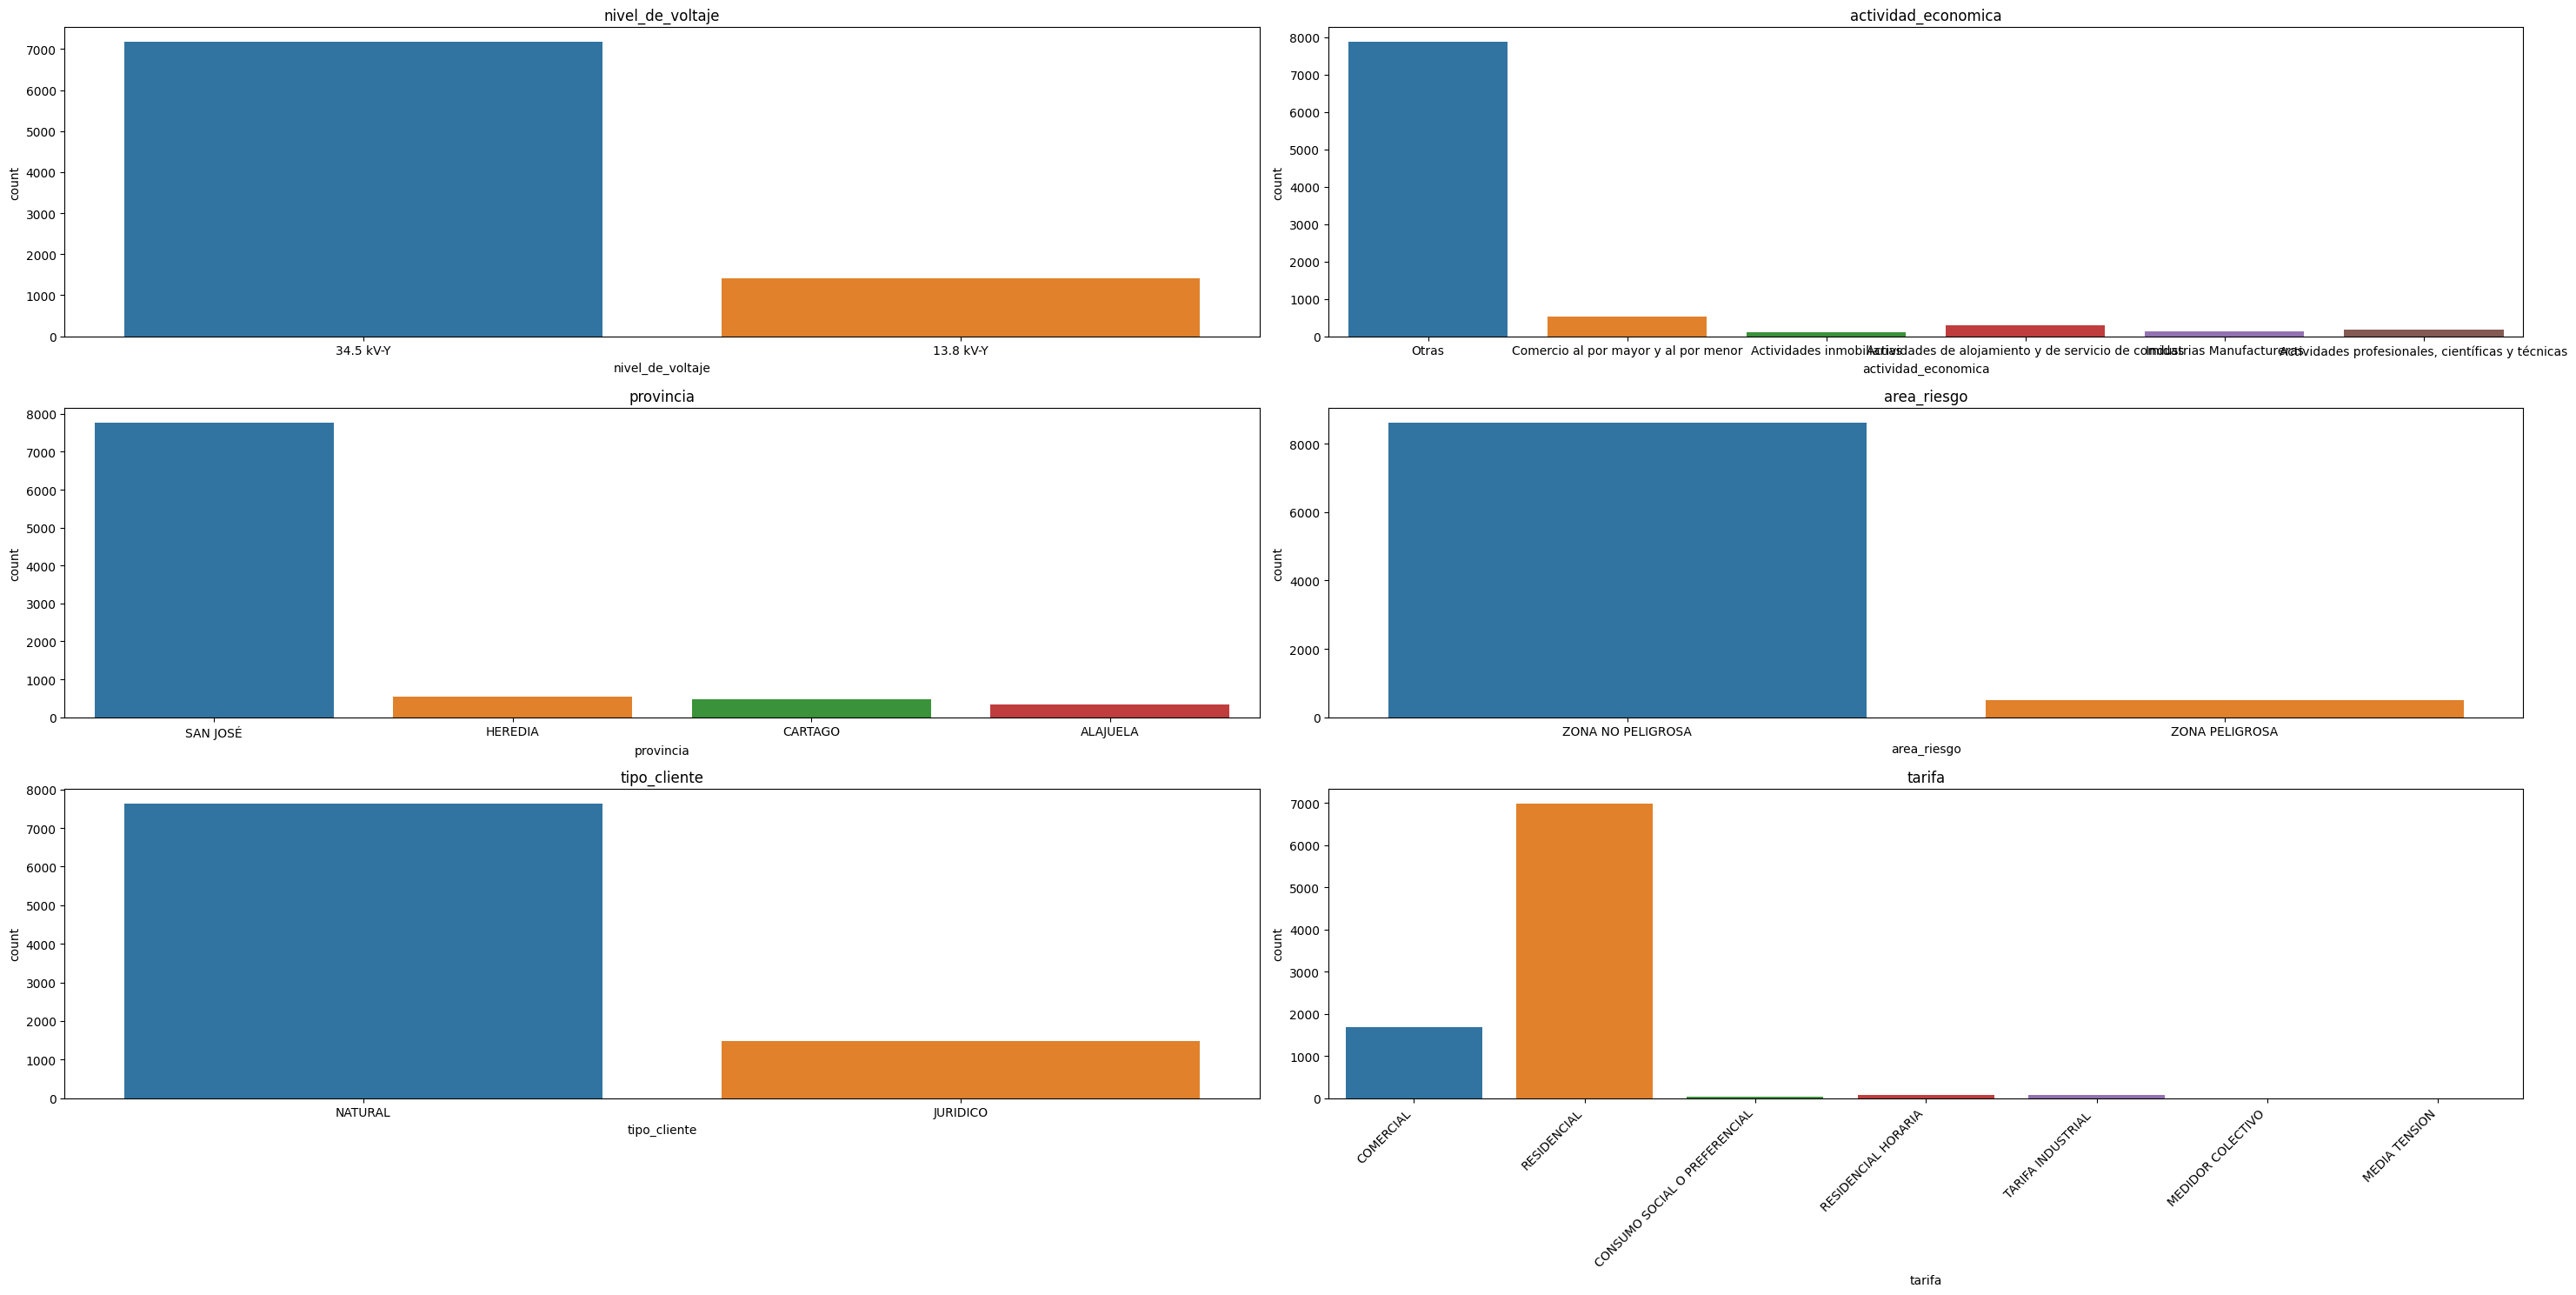

In [ ]:
#Visualización de frecuencia de instancias para variables categóricas
plot_multiples_graficas(df,catCols, 2, 3, 'c', None, (30,15))


In [ ]:
#Lista de variables numéricas

numCols=df.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

df[numCols] = df[numCols].astype(float)

df[numCols].head()

,was_fraud,N155,N158,N159,N161,N166,N167,N188,N203,N225,...,N623,N624,N625,N645,N647,N650,N651,N654,N661,N662
0,1.0,4.0,-0.003100,0.004290,379.000000,0.212561,0.281981,221.42,20.0,786.0,...,1.0,1.0,1.0,0.001938,0.000306,0.000216,0.000283,475.0,0.0,0.0
1,1.0,0.0,-0.008446,-0.005802,258.916667,0.212561,0.281981,177.87,0.0,312.0,...,1.0,1.0,1.0,0.002214,0.000885,0.001020,0.000879,243.0,0.0,0.0
2,1.0,0.0,-0.001334,-0.004174,257.750000,0.212561,0.281981,220.91,0.0,524.0,...,1.0,1.0,1.0,-0.000243,0.000108,0.000028,0.000101,267.0,0.0,0.0
3,1.0,0.0,0.011478,-0.005792,193.583333,0.212561,0.281981,257.01,0.0,1491.0,...,1.0,1.0,1.0,-0.002185,-0.000572,-0.000408,-0.000633,342.0,0.0,16.0
4,1.0,0.0,0.010146,0.006548,257.833333,0.212561,0.281981,209.60,0.0,680.0,...,1.0,1.0,1.0,-0.001774,0.000070,0.000238,-0.000074,323.0,0.0,0.0


In [ ]:
print(df[numCols].columns.tolist())

['was_fraud', 'N155', 'N158', 'N159', 'N161', 'N166', 'N167', 'N188', 'N203', 'N225', 'N229', 'N232', 'N234', 'N257', 'N260', 'N267', 'N289', 'N315', 'N326', 'N351', 'N360', 'N368', 'N370', 'N381', 'N383', 'N388', 'N390', 'N402', 'N404', 'N429', 'N430', 'N512', 'N514', 'N515', 'N516', 'N517', 'N520', 'N522', 'N523', 'N524', 'N525', 'N543', 'N554', 'N574', 'N575', 'N584', 'N585', 'N591', 'N594', 'N620', 'N621', 'N622', 'N623', 'N624', 'N625', 'N645', 'N647', 'N650', 'N651', 'N654', 'N661', 'N662']


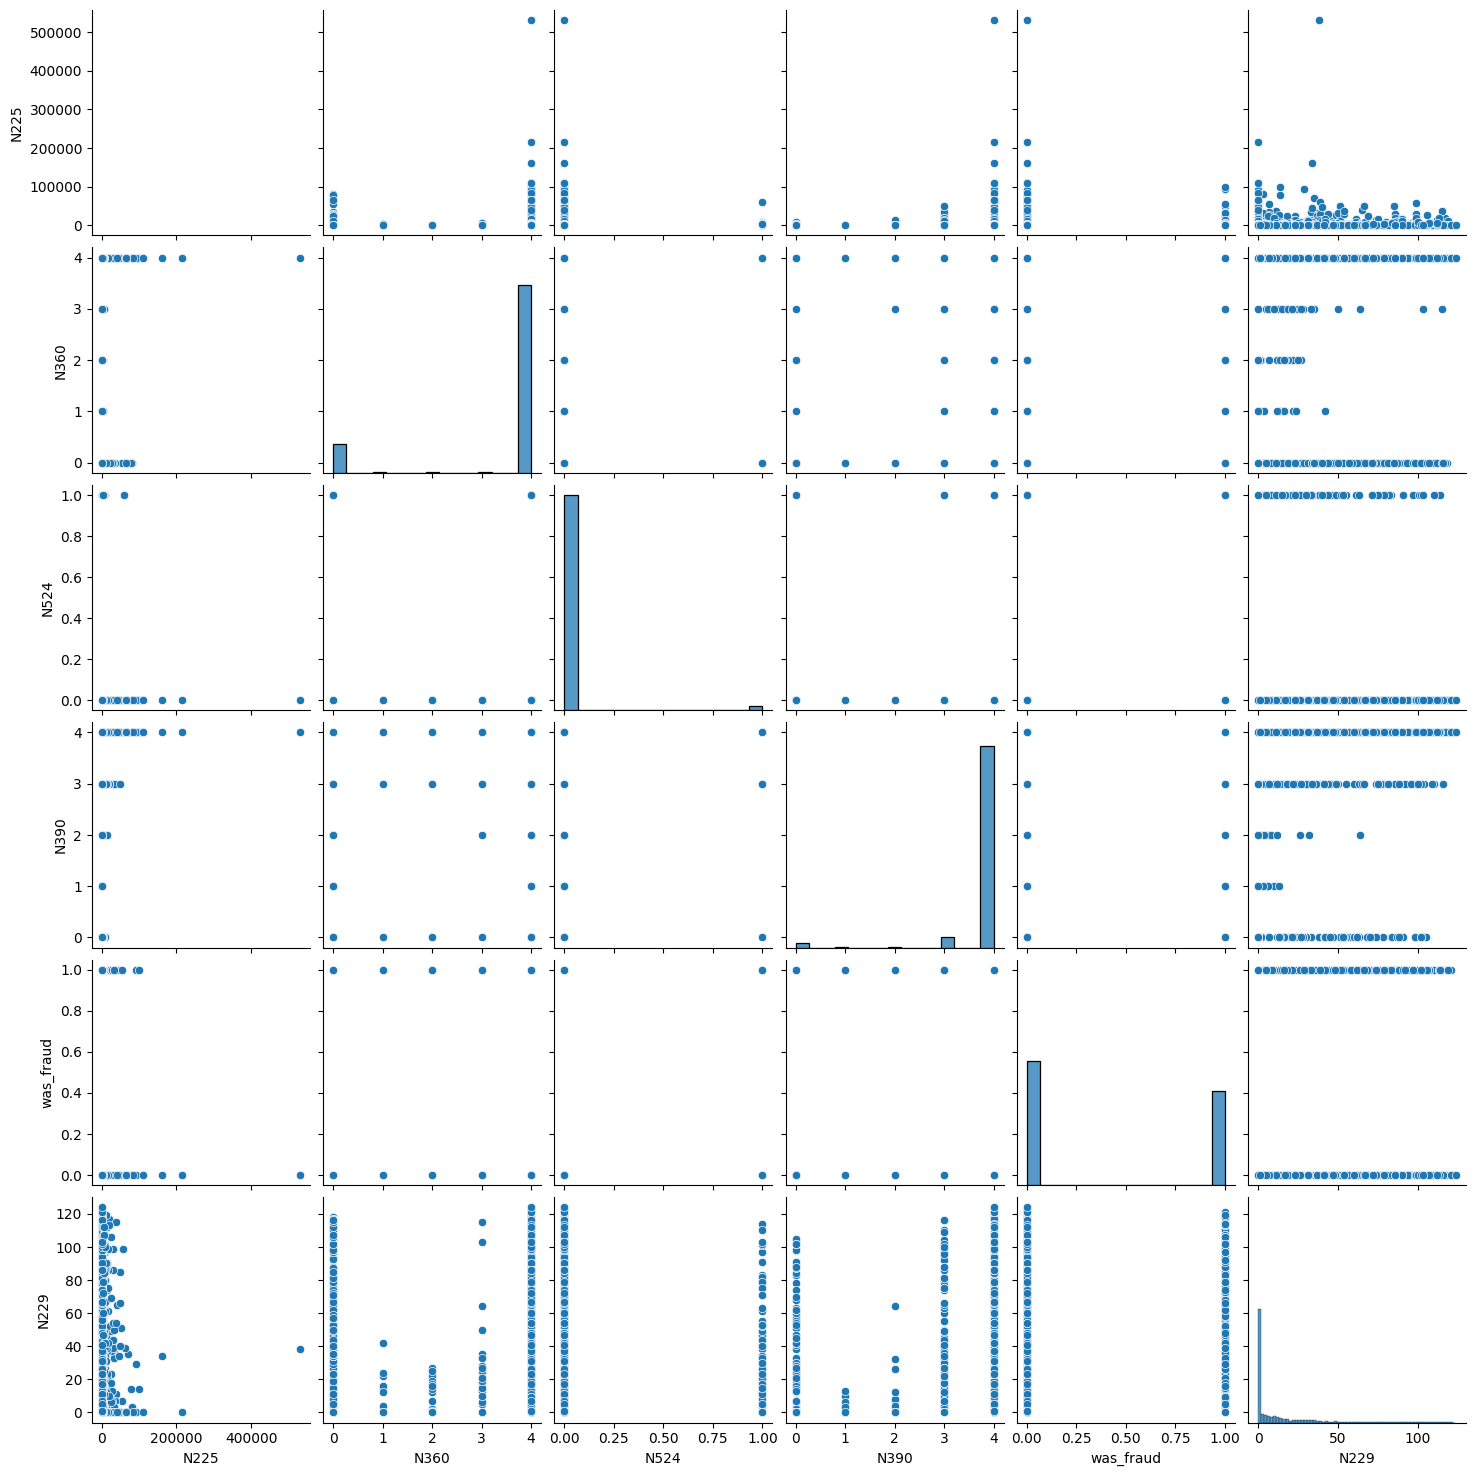

In [ ]:
#Gráficos de dispersión para todas las combinaciones posibles de las variables numéricas seleccionadas en un subconjunto de 36 de las 62 columnas en total

#Subconjunto de columnas
numCols_subset = np.random.choice(numCols, size=6, replace=False)

# Crea el pairplot con el subconjunto de columnas numéricas
sns.pairplot(df[numCols_subset])
plt.show()

#### 4.2 Variables de salida




In [ ]:
# Distriución de la variable de salida

data =df.groupby('was_fraud').was_fraud.count().sort_values(ascending=False)
print(data)

was_fraud
0.0    5163
1.0    3938
Name: was_fraud, dtype: int64


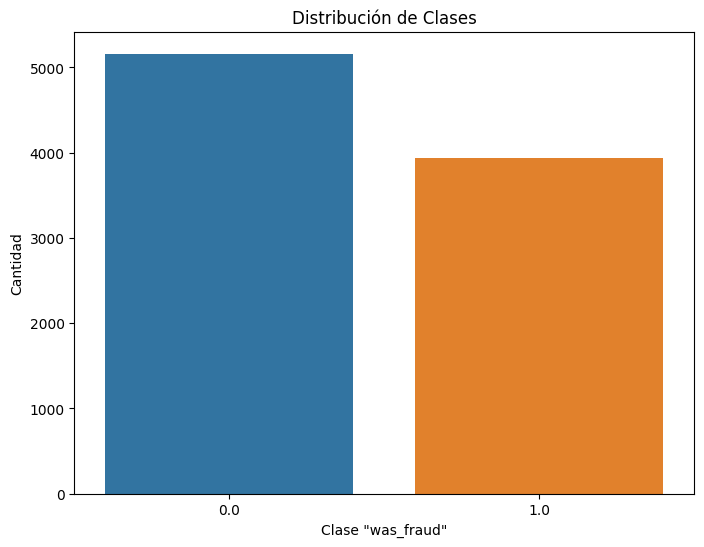

In [ ]:
# Crear la gráfica de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=data.index, y=data.values)

# Etiquetar los ejes y dar un título a la gráfica
plt.xlabel('Clase "was_fraud"')
plt.ylabel('Cantidad')
plt.title('Distribución de Clases')

# Mostrar la gráfica
plt.show()


## 5. Preparación de datos

#### 5.1 Imputación de datos

In [ ]:
# Imputa los valores faltantes en las columnas numéricas con la mediana
df = df.fillna(df.median())


<ipython-input-31-abe69de88da4>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.median())


In [ ]:
# Encuentra las columnas categóricas que tienen valores NaN
catCols = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).isnull().any()]

# Imprime las columnas categóricas con valores NaN
print("Columnas categóricas con valores NaN:\n\n")
for col in catCols:
    num_nans = df[col].isnull().sum()
    print(f"{col}: {num_nans} valores NaN de {len(df)}")

# Crea el imputador con la estrategia "most_frequent"
imputer = SimpleImputer(strategy="most_frequent")

# Imputa los valores faltantes en las columnas categóricas
df[catCols] = imputer.fit_transform(df[catCols])


Columnas categóricas con valores NaN:


nivel_de_voltaje: 520 valores NaN de 9101
tarifa: 235 valores NaN de 9101


#### 5.2 Manejo de valores atípicos para las variables de entrada




In [ ]:
"""
Se realiza una búsqueda de hiperparámetros para encontrar el valor óptimo de n_neighbors que maximiza
la detección de valores atípicos en las instalaciones de energía eléctrica utilizando el modelo LocalOutlierFactor.
El mejor valor de n_neighbors fue 30 lo que indica que el modelo consideró 30 puntos vecinos más cercanos para evaluar la atipicidad de un punto de datos.
El puntaje de 1.1079047837775062 sugiere que, en este escenario particular, el modelo logró identificar valores atípicos de manera eficiente cuando se configuró con 30 vecinos más cercanos.
"""

# Datos
X = df[numCols]

# Lista de valores de n_neighbors a probar
n_neighbors_values = [10, 14, 20, 25, 30]

best_score = float('-inf')  # Inicializar con un valor bajo
best_n_neighbors = None

for n_neighbors in n_neighbors_values:
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.1)
    y_pred = lof.fit_predict(X)

    # Calcular una métrica apropiada para la detección de valores atípicos
    score = -lof.negative_outlier_factor_.mean()

    if score > best_score:
        best_score = score
        best_n_neighbors = n_neighbors

print(f"El mejor valor de n_neighbors es {best_n_neighbors} con un puntaje de {best_score}")


El mejor valor de n_neighbors es 30 con un puntaje de 1.107905393889359


In [ ]:
#utilización de LocalOutlierFactor con 30 vecinos para identificar valores atípicos en las variables de entrada

# crear un objeto LocalOutlierFactor con n_neighbors=30
lof = LocalOutlierFactor(n_neighbors=30, contamination=0.1)

# identificar los valires atípicos por medio de lof
y_pred = lof.fit_predict(df[numCols])

# Identificar los índices de los valores atípicos
outliers = y_pred == -1

print('Indices de valores atípicos: ', df[outliers].index.tolist())

Indices de valores atípicos:  [3, 27, 34, 37, 39, 41, 48, 52, 53, 64, 81, 82, 87, 101, 116, 126, 135, 154, 165, 180, 188, 201, 206, 208, 209, 217, 233, 239, 243, 251, 259, 260, 266, 270, 285, 292, 294, 305, 307, 309, 311, 318, 323, 325, 355, 361, 367, 371, 372, 382, 399, 409, 422, 484, 489, 492, 493, 498, 503, 514, 531, 534, 548, 549, 556, 591, 598, 656, 671, 682, 687, 696, 699, 703, 704, 736, 738, 754, 775, 789, 796, 806, 810, 813, 834, 851, 856, 864, 868, 870, 871, 884, 898, 902, 916, 937, 958, 977, 985, 1007, 1030, 1033, 1035, 1048, 1052, 1062, 1068, 1096, 1103, 1126, 1127, 1158, 1176, 1181, 1187, 1213, 1275, 1276, 1277, 1288, 1295, 1300, 1302, 1303, 1305, 1306, 1309, 1316, 1321, 1337, 1344, 1357, 1365, 1392, 1414, 1428, 1432, 1434, 1462, 1466, 1469, 1484, 1487, 1493, 1496, 1499, 1529, 1535, 1536, 1554, 1558, 1573, 1593, 1594, 1598, 1615, 1620, 1626, 1634, 1637, 1642, 1644, 1654, 1666, 1670, 1673, 1685, 1704, 1708, 1729, 1732, 1766, 1767, 1771, 1774, 1778, 1781, 1782, 1800, 1801, 18

In [ ]:
# Eliminar los valores atípicos del dataframe original
df = df.loc[~outliers]

print(f"Número de registros despues de la eliminacion de outlaiers {len(df)}")

Número de registros despues de la eliminacion de outlaiers 8191


### 5.3 Transformaciones

In [ ]:
#Para reducir la dimensionalidad y evitar problemas de sobreajuste, eliminamos categorias pequeñas de las columnas tarifa
#Eliminación de categorias pequeñas para la variable tarifa, .

df['tarifa'].value_counts().sort_values(ascending=False)

RESIDENCIAL                      6494
COMERCIAL                        1545
RESIDENCIAL HORARIA                62
TARIFA INDUSTRIAL                  62
CONSUMO SOCIAL O PREFERENCIAL      27
MEDIDOR COLECTIVO                   1
Name: tarifa, dtype: int64

In [ ]:
#Reemplazo de valores para la agrupación de categorías

#Diccionario con los reemplazos a realizar
reemplazos = {  "RESIDENCIAL": "HOGAR"
              , "RESIDENCIAL HORARIA": "HOGAR"
              , "CONSUMO SOCIAL O PREFERENCIAL": "HOGAR"
              , "MEDIDOR COLECTIVO": "HOGAR"
              , "COMERCIAL": "INDUSTRIA Y COMERCIO"
              , "TARIFA INDUSTRIAL": "INDUSTRIA Y COMERCIO"}


#Se reemplazan los valores de acuerdo con el diccionario creado anteriormente
df['tarifa'] = df['tarifa'].map(reemplazos).fillna(df['tarifa'])


#Visualización de las nuevos valores agrupados para la categoria 'tarifa'
df['tarifa'].value_counts().sort_values(ascending=False)


HOGAR                   6584
INDUSTRIA Y COMERCIO    1545
TARIFA INDUSTRIAL         62
Name: tarifa, dtype: int64

### 5.4 Sobremuestreo (oversampling)

In [ ]:
# Se crea un objeto RandomOverSampler que permite crear copias aleatorias de las muestras de la clase
# minoritaria para igualar el número de muestras entre las diferentes clases.
oversampler = RandomOverSampler()

# Se realiza el sobremuestreo para las variables de entrada y salida
X_resampled, y_resampled = oversampler.fit_resample(df.drop('was_fraud', axis=1), df['was_fraud'])

# Se crean dos dataframes con las variables de entrada y otro con la variable de salida a partir del proceso anterior
df1 = pd.DataFrame(X_resampled, columns=df.columns.drop('was_fraud'))
df2 = pd.DataFrame(y_resampled)

# Se concatenan los dataframes horizontalmente
df_balanced = pd.concat([df1, df2], axis=1)

In [ ]:
# Dataset balanceado
df_balanced.head()

,nivel_de_voltaje,actividad_economica,provincia,area_riesgo,tipo_cliente,tarifa,N155,N158,N159,N161,...,N624,N625,N645,N647,N650,N651,N654,N661,N662,was_fraud
0,34.5 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,HOGAR,4.0,-0.003100,0.004290,379.000000,...,1.0,1.0,0.001938,0.000306,0.000216,0.000283,475.0,0.0,0.0,1.0
1,13.8 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,HOGAR,0.0,-0.008446,-0.005802,258.916667,...,1.0,1.0,0.002214,0.000885,0.001020,0.000879,243.0,0.0,0.0,1.0
2,34.5 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,HOGAR,0.0,-0.001334,-0.004174,257.750000,...,1.0,1.0,-0.000243,0.000108,0.000028,0.000101,267.0,0.0,0.0,1.0
3,34.5 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,HOGAR,0.0,0.010146,0.006548,257.833333,...,1.0,1.0,-0.001774,0.000070,0.000238,-0.000074,323.0,0.0,0.0,1.0
4,34.5 kV-Y,Otras,SAN JOSÉ,ZONA NO PELIGROSA,NATURAL,HOGAR,0.0,0.004459,0.004537,158.666667,...,1.0,1.0,0.001553,0.000056,0.000076,0.000139,1.0,0.0,0.0,1.0


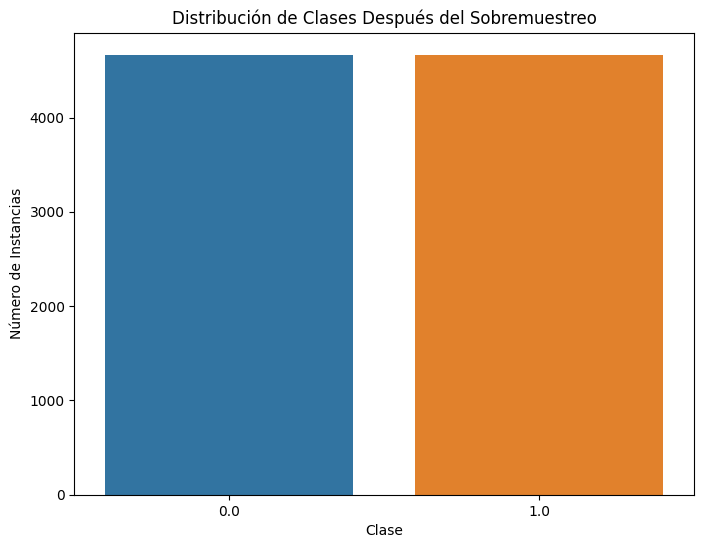

In [ ]:

# Contar las instancias de cada clase en el DataFrame df_balanced
class_counts = df_balanced['was_fraud'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)

# Agregar etiquetas y título al gráfico
plt.xlabel('Clase')
plt.ylabel('Número de Instancias')
plt.title('Distribución de Clases Después del Sobremuestreo')

# Mostrar el gráfico
plt.show()

### 5.5 Creación de Variables Dummies

In [ ]:
# Aplicación de la función de usuario Dummies: one-hot encoding

df =pd.get_dummies(df_balanced, drop_first=1)
df.head()

,N155,N158,N159,N161,N166,N167,N188,N203,N225,N229,...,actividad_economica_Comercio al por mayor y al por menor,actividad_economica_Industrias Manufactureras,actividad_economica_Otras,provincia_CARTAGO,provincia_HEREDIA,provincia_SAN JOSÉ,area_riesgo_ZONA PELIGROSA,tipo_cliente_NATURAL,tarifa_INDUSTRIA Y COMERCIO,tarifa_TARIFA INDUSTRIAL
0,4.0,-0.003100,0.004290,379.000000,0.212561,0.281981,221.42,20.0,786.0,13.0,...,0,0,1,0,0,1,0,1,0,0
1,0.0,-0.008446,-0.005802,258.916667,0.212561,0.281981,177.87,0.0,312.0,13.0,...,0,0,1,0,0,1,0,1,0,0
2,0.0,-0.001334,-0.004174,257.750000,0.212561,0.281981,220.91,0.0,524.0,36.0,...,0,0,1,0,0,1,0,1,0,0
3,0.0,0.010146,0.006548,257.833333,0.212561,0.281981,209.60,0.0,680.0,71.0,...,0,0,1,0,0,1,0,1,0,0
4,0.0,0.004459,0.004537,158.666667,0.212561,0.281981,235.54,0.0,333.0,49.0,...,0,0,1,0,0,1,0,1,0,0


In [ ]:
df.to_csv('resultado_final_consumos.csv', index=False)